# Мастерская данных - Маркетинг

## Введение

### Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

### Цели исследования

Предсказать вероятность покупки в течение 90 дней

### План работы

- **Загрузка данных** - выполняется импорт необходимых библиотек, загрузка исходных данных;

- **Предобработка данных** - устраняются дубликаты, пропуски, ошибки в данных;

- **Исследовательский анализ данных** - выполняется анализ предоставленной информации - выявляются основные зависимости и распределения в данных;

- **Подготовка данных** - выполняется подготовка признаков с помощью пайплайнов;

- **Обучение моделей** - на данном этапе обучаются модели, отбирается наилучшая по метрике ROC-AUC.

#### Общий вывод по проекту

Общий вывод по проекту должен содержать:

- описание задачи;

- описание всех проделанных этапов работы;

- выводы и предложения для бизнеса.

In [3]:
#!pip install scikit-learn==1.3
#!pip install category_encoders

  Obtaining dependency information for scikit-learn==1.3 from https://files.pythonhosted.org/packages/77/85/bff3a1e818ec6aa3dd466ff4f4b0a727db9fdb41f2e849747ad902ddbe95/scikit_learn-1.3.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.2 MB 653.6 kB/s eta 0:00:15
   ---------------------------------------- 0.1/9.2 MB 751.6 kB/s eta 0:00:13
   ---------------------------------------- 0.1/9.2 MB 819.2 kB/s eta 0:00:12
    --------------------------------------- 0.2/9.2 MB 807.1 kB/s eta 0:00:12
    --------------------------------------- 0.2/9.2 MB 831.5 kB/s eta 0:00:11
    --------------------------------------- 0.2/9.2 MB 811.5 kB/s eta 0:00:12
   - -------------------------------------- 0.3/9.2 MB 774.0 kB/s eta 0:00:12
   - -------------------------------------- 0.3/9.2 MB 761.4 kB/s eta 0:00:12
   - ----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.1 requires scikit-learn>=1.6.0, but you have scikit-learn 1.3.0 which is incompatible.


  Obtaining dependency information for scikit-learn>=1.6.0 from https://files.pythonhosted.org/packages/a1/a6/c5b78606743a1f28eae8f11973de6613a5ee87366796583fb74c67d54939/scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import traceback
import seaborn as sns
import re
import shap
import phik
import sklearn
import missingno as msno
import json
import ast

from scipy import stats as st

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# билбилотеки для определения мультиколлинеарности
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split

# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from category_encoders import TargetEncoder

# дополнительные классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 

# метрики
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from phik.report import plot_correlation_matrix
from phik import report, resources

# для отключения предупреждений
from warnings import simplefilter

# загружаем класс "цвет" для использования при форматировании текста
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

pd.set_option('display.float_format', '{:,.2f}'.format) # корректировка вывода чисел до точности двух знаков после запятой

## Загрузка данных

В переменную `data_path` нужно записать путь до папки с исходными данными

In [5]:
data_path = 'D:\\Музюкин\\Программирование\\Мастерская 2'

In [6]:
apparel_messages = pd.read_csv(data_path+'\\apparel-messages.csv')
apparel_purchases = pd.read_csv(data_path+'\\apparel-purchases.csv')
apparel_target_binary = pd.read_csv(data_path+'\\apparel-target_binary.csv')
full_campaign_daily_event = pd.read_csv(data_path+'\\full_campaign_daily_event.csv')
full_campaign_daily_event_channel = pd.read_csv(data_path+'\\full_campaign_daily_event_channel.csv')

### Раздел с собственными функциями

В данном разделе содержатся собственные функции, которые используются в проекте.

In [7]:
def safe_parse(json_str):
    '''Функция для превращения строк-списков category_ids в реальные списки'''
    # Проверка на NaN/пустые строки/None
    if pd.isna(json_str) or not str(json_str).strip():
        return []
    
    # Удаляем лишние пробелы
    json_str = str(json_str).strip()
    
    try:
        # Сначала пробуем как JSON (двойные кавычки)
        parsed = json.loads(json_str)
    except json.JSONDecodeError:
        try:
            # Пробуем как Python-литерал (одинарные кавычки)
            parsed = ast.literal_eval(json_str)
        except (ValueError, SyntaxError):
            # Если вообще не парсится - возвращаем пустой список
            return []
    
    # Обрабатываем результат парсинга
    if isinstance(parsed, list):
        result = []
        for item in parsed:
            try:
                if item is not None:  # Проверка на None
                    result.append(int(item))
            except (ValueError, TypeError):
                continue  # Пропускаем неконвертируемые значения
        return result
    else:
        return []  # Если результат не список

In [8]:
def data_analysis_cat(df, max_unique=10, figsize=(10, 10)):
    """Функция визуализирует категориальные данные датафрейма df в виде круговых диаграмм.
    max_unique - максимальное количество уникальных значений столбца. Все, что больше, не будет отображаться на диаграммах
    figsize - размер графиков"""
    try:
        
        object_columns = df.select_dtypes(include='object').columns.tolist()
        
        print('Общие категориальные характеристики датафрейма:')
        display(df[object_columns].describe(include=[object]).T)
        print()
        print(f'Число категориальных признаков в датафрейме: {len(object_columns)}')
        print()
        
        for col in object_columns:
            if len(df[col].unique()) > max_unique:
                object_columns.remove(col)
        
        num_of_rows = int(np.ceil(len(object_columns) / 2))
        
        if num_of_rows==1: # вывод графиков в случае, если в датафрейме только один столбец с категориальными данными
            for col in object_columns:
                fig, ax =plt.subplots(figsize=figsize)
                ax.pie(df[col].value_counts(), autopct='%.0f%%', labels = df[col].value_counts().index,
                           colors=sns.color_palette('pastel')) 
                ax.set_title(f'Распределение данных\n в столбце "{col}"')
                plt.suptitle('Графическое представление категориальных данных', ha='center', fontsize='xx-large')
                plt.show()
        else: # вывод графиков в случае, если в датафрейме больше одного столбца с категориальными данными
            num_of_cols = 2
            fig, ax =plt.subplots(num_of_rows, num_of_cols, figsize=figsize, sharex='all', sharey='all')
            i = 0
            j = 0
            for col in object_columns:
                ax[i, j].pie(df[col].value_counts(), autopct='%.0f%%', labels = df[col].value_counts().index,
                           colors=sns.color_palette('pastel')) 
                ax[i, j].set_title(f'Распределение данных\n в столбце "{col}"')
                if j == num_of_cols-1:
                    i += 1
                    j = 0
                else:
                    j +=1
            plt.suptitle('Графическое представление категориальных данных', ha='center', fontsize='xx-large')
            plt.show()
        
    except Exception:
        traceback.print_exc()

In [9]:
def data_analysis_num(df, bins=50, min_max=(0, 0)):
    """Функция визуализирует количественные данные датафрейма df. 
    Переменная bins - число корзин для гистограмм.
    Переменная min_max - кортеж, который принимает границы минимума и максимума по оси Ох для графиков."""
    try:
        numeric_columns = df.select_dtypes(include='number').columns.tolist()
        
        print(f'Общие числовые характеристики датафрейма:')
        display(df[numeric_columns].describe().T)
        print()
        print(f'Число количественных признаков в датафрейме: {len(numeric_columns)}')
        print()
        num_of_rows = int(len(numeric_columns))
        num_of_cols = 2
        figsize=(12, 5.3*num_of_rows) # расчет масшатаба графика. Коэффициенты подобраны вручную
        fig, ax =plt.subplots(num_of_rows, num_of_cols, figsize=figsize)
        
        
        if num_of_rows==1: # вывод графиков в случае, если в датафрейме только один столбец с категориальными данными
            for col in numeric_columns:
                g = sns.histplot(df[col], bins=bins, ax=ax[0], kde=True)
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                g.set(xlabel=f'Значения столбца "{col}"', ylabel=f'Частота встречаемости',
                  title=f'Распределение данных\n в столбце "{col}"')
                g = sns.boxplot(x=df[col], showmeans=True, ax=ax[1], width=0.25)
                g.set(title=f'Диаграмма разброса данных\n в столбце "{col}"')
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                
        else: # вывод графиков в случае, если в датафрейме больше одного столбца с категориальными данными
            i = 0
            for col in numeric_columns:
                g = sns.histplot(df[col], bins=bins, ax=ax[i, 0], kde=True)
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                g.set(xlabel=f'Значения столбца "{col}"', ylabel=f'Частота встречаемости',
                  title=f'Распределение данных\n в столбце "{col}"')
                g = sns.boxplot(x=df[col], showmeans=True, ax=ax[i, 1], width=0.25)
                g.set(title=f'Диаграмма разброса данных\n в столбце "{col}"')
                if min_max!=(0,0):
                    g.set(xlim=min_max)
                i += 1
        plt.suptitle('Гистограммы распределения и диаграммы разброса числовых данных', ha='center', fontsize='xx-large')      
        plt.show()
    except Exception:
        traceback.print_exc()

In [81]:
def conf_matrix(y_test, pred):
    '''Функция принимает на вход значения прогноза и истинные значения. На выходе выводит на экран значения
    метрик accuracy, recall, precision и выводит матрицу ошибок.'''
    try:
        cm = confusion_matrix(y_test, pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
        plt.ylabel('Реальное значение')
        plt.xlabel('Предсказанное значение')
        plt.title('Матрица ошибок')
        plt.show()    
    except Exception:
        traceback.print_exc() 

### Обзор загруженных данных

Выведем первые пять строк каждого датафрейма:

In [10]:
# в данном словаре будем хранить названия и ссылки на исходные датафреймы, чтобы иметь возможность 
# быстрого обращения к ним в цикле
df_dict = {
    'apparel_messages': apparel_messages,
    'apparel_purchases': apparel_purchases,
    'apparel_target_binary': apparel_target_binary,
    'full_campaign_daily_event': full_campaign_daily_event,
    'full_campaign_daily_event_channel': full_campaign_daily_event_channel
}

for df_name in df_dict.keys():
    print(f'Первые пять строк датафрейма {color.BOLD}{df_name}{color.END}:')
    display(df_dict[df_name].head())
    print()

Первые пять строк датафрейма apparel_messages:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52



Первые пять строк датафрейма apparel_purchases:


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,"1,999.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,"2,499.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,"6,499.00","['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,"4,999.00","['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,"4,999.00","['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843



Первые пять строк датафрейма apparel_target_binary:


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0



Первые пять строк датафрейма full_campaign_daily_event:


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0



Первые пять строк датафрейма full_campaign_daily_event_channel:


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Выведем общую информацию о каждом датафрейме:

In [11]:
for df_name in df_dict.keys():
    print(f'{color.BOLD}Общая информация о датафрейме {df_name}{color.END}:')
    df_dict[df_name].info(show_counts=True)
    print()

Общая информация о датафрейме apparel_messages:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB

Общая информация о датафрейме apparel_purchases:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   pric

Анализ общей информации о каждом датафрейме показал следующее:
- ни в одном из датафреймов нет пропусков;
- требуется привести данные с датой и временем к соответствующему типу;
- у первых двух датафреймов нумерация индексов не сквозная. Необходимо сделать сброс индексов, чтобы привести ее к сквозной. Это будет важно на этапе агрегирования таблиц.

Выполним сброс индексов в первых двух датафреймах:

In [12]:
apparel_messages.reset_index(drop=True, inplace=True)
apparel_purchases.reset_index(drop=True, inplace=True)

Выполним изменение типа данных, содержащих значения даты и времени:

In [13]:
apparel_messages['date'] = pd.to_datetime(apparel_messages['date'], format='%Y-%m-%d')
apparel_messages['created_at'] = pd.to_datetime(apparel_messages['created_at'], format='%Y-%m-%d %H:%M:%S')
apparel_purchases['date'] = pd.to_datetime(apparel_purchases['date'], format='%Y-%m-%d')
full_campaign_daily_event['date'] = pd.to_datetime(full_campaign_daily_event['date'], format='%Y-%m-%d')
full_campaign_daily_event_channel['date'] = pd.to_datetime(full_campaign_daily_event_channel['date'], format='%Y-%m-%d')

Убедимся, что теперь столбцы с датой имеют соответствующий тип, а нумерация индексов - сквозная:

In [14]:
for df_name in df_dict.keys():
    print(f'{color.BOLD}Общая информация о датафрейме {df_name}{color.END}:')
    df_dict[df_name].info()
    print()

Общая информация о датафрейме apparel_messages:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB

Общая информация о датафрейме apparel_purchases:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   categ

### Выводы по разделу

Выполнена загрузка исходных данных в пять таблиц DataFrame:

- `apparel_messages` - таблица, которая содержит данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук;
- `apparel-messages` - таблица с данными о рассылках, которые были отправлены клиентам из таблицы покупок;
- `target` - таблица с данными о том, совершил клиент покупку в целевом периоде или нет;
- `full_campaign_daily_event` - таблица с агрегированными данными из общей базы рассылок по дням и типам событий;
- `full_campaign_daily_event_channel` - таблица с агрегированными данными по дням с учетом событий и каналов рассылки

Анализ общей информации о каждом датафрейме показал, что во всех пяти **отсутствуют пропущенные значения**. Потребовалось изменение типа данных столбцов, содержащих данные о дате и времени, а также сброс индексов в первых двух таблицах.

##  Предобработка данных

### Анализ на наличие дубликатов

Проведем анализ каждого датафрейма на наличие строк-дублей:

In [15]:
for df_name in df_dict.keys():
    print(f'{color.BOLD}Количество дубликатов в датафрейме {df_name}{color.END}:')
    print(df_dict[df_name].duplicated().sum())
    print()

Количество дубликатов в датафрейме apparel_messages:
48610

Количество дубликатов в датафрейме apparel_purchases:
73020

Количество дубликатов в датафрейме apparel_target_binary:
0

Количество дубликатов в датафрейме full_campaign_daily_event:
0

Количество дубликатов в датафрейме full_campaign_daily_event_channel:
0



Как видим, в первых двух датафреймах присутствует большое число дублей. Выполним их удаление, а также сброс индексов:

In [16]:
apparel_messages.drop_duplicates(inplace=True, ignore_index=True)
apparel_purchases.drop_duplicates(inplace=True, ignore_index=True)


Убедимся, что дублей не осталось:

In [17]:
for df_name in df_dict.keys():
    print(f'{color.BOLD}Количество дубликатов в датафрейме {df_name}{color.END}:')
    print(df_dict[df_name].duplicated().sum())
    print()

Количество дубликатов в датафрейме apparel_messages:
0

Количество дубликатов в датафрейме apparel_purchases:
0

Количество дубликатов в датафрейме apparel_target_binary:
0

Количество дубликатов в датафрейме full_campaign_daily_event:
0

Количество дубликатов в датафрейме full_campaign_daily_event_channel:
0



### Анализ уникальных значений

Предварительный обзор исходных данных показал, что некоторые столбцы целесообразно проверить на уникальные значения. К таким столбцам можно отнести те, которые содержат строковые данные. Выведем уникальные значения каждого такого столбца каждого датафрейма.

In [18]:
for df_name in df_dict.keys():
    df = df_dict[df_name]
    object_columns = df.select_dtypes(include='object').columns.tolist() # запишем в эту переменную названия столбцов с не числовыми данными
    if not object_columns:
        print(f'Датафрейм {color.BOLD}{df_name}{color.END} не содержит строковых данных.')
    else:
        print(f'Датафрейм {color.BOLD}{df_name}{color.END}:')
        print()
        for col in object_columns:
            un_vals = df[col].unique()
            un_vals_count = len(un_vals)
            print(f'Общее количество уникальных значений в столбце {color.BOLD}{col:<30}{color.END}: {un_vals_count}, шт')
            print(f'Уникальные значения столбца {color.BOLD}{col:<30}{color.END}: {un_vals}')
            print()

Датафрейм apparel_messages:

Общее количество уникальных значений в столбце message_id                    : 9061667, шт
Уникальные значения столбца message_id                    : ['1515915625626736623-4439-6283415ac07ea'
 '1515915625490086521-4439-62834150016dd'
 '1515915625553578558-4439-6283415b36b4f' ...
 '1515915625490988866-14656-65ce97f929ca4'
 '1515915625617022616-14656-65ce97f9299fe'
 '1515915625491736359-14656-65ce97f92a3fd']

Общее количество уникальных значений в столбце event                         : 11, шт
Уникальные значения столбца event                         : ['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']

Общее количество уникальных значений в столбце channel                       : 2, шт
Уникальные значения столбца channel                       : ['email' 'mobile_push']

Датафрейм apparel_purchases:

Общее количество уникальных значений в столбце category_ids                  : 933, шт
Уника

Также выполним проверку на уникальность `client_id` в основных датафреймах.

In [19]:
for df_name in df_dict.keys():
    df = df_dict[df_name]
    if 'client_id' in df.columns:
        un_vals_count = len(df['client_id'].unique())
        print(f'Число уникальных значений в столбце client_id датафрейма {color.BOLD}{df_name}{color.END}: {un_vals_count}, шт')       
    else:
        continue


Число уникальных значений в столбце client_id датафрейма apparel_messages: 53329, шт
Число уникальных значений в столбце client_id датафрейма apparel_purchases: 49849, шт
Число уникальных значений в столбце client_id датафрейма apparel_target_binary: 49849, шт


Как видим, в датафрейме `apparel_messages` есть клиенты, id которых отсутствует в других датафреймах.

### Предварительные выводы:

Удалены дубликаты в датафреймах `apparel_messages` и `apparel-messages`. Анализ на уникальность значений показал, что `apparel_messages` содержит `client_id`, которые отсутствуют в `apparel-messages` и `apparel_target_binary`.

На основе анализа уникальных значений датафреймов `apparel_messages` и `apparel_purchases` выдвинуты следующие гипотезы:
- **Гипотеза №1**: значения данных в столбце `message_id` состоят из трех частей: первая часть совпадает со значением `client_id`, вторая часть совпадает со значением `bulk_campaign_id`, третья относится непосредственно к `message_id`. Аналогичная гипотеза применима к столбцу `message_id` в датафрейме `apparel_purchases`. При этом, третья часть, по всей видимости, представлена в шестнадцатеричной системе счисления. Возможно, стоит попробовать преобразовать ее к десятеричной;
- **Гипотеза №2**: в датафрейме `apparel_purchases` столбец `category_ids` содержит большое число уникальных значений - 933 шт. При этом, сами элементы состоят из нескольких вложенных значений. Возможно, что уникальных вложенных значений среди них значительно меньше, чем 933 шт. Если это так, то можно будет подумать о создании нового признака на основе уникальности категорий. Также нужно представить вложенные значения в более удобном виде, так как сейчас каждый список представлен как строка.

**Проверка гипотезы №1**

Для проверки выдвинутой гипотезы необходимо пройтись по каждой строчке датафреймов `apparel_messages` и `apparel_purchases` и провести сравнение первой и второй части значения `message_id` с `client_id` и `bulk_campaign_id`, соответственно. Разделителем частей будет выступать символ "-". Перед сравнением также необходимо привести данные к числовому типу. Результат сравнения запишем в отдельную переменную.

In [20]:
# создаем новые дф, в которых значения столбца message_id будут разделены по символу -
am_message_id_split = apparel_messages['message_id'].str.split(pat='-', expand=True)
ap_message_id_split = apparel_purchases['message_id'].str.split(pat='-', expand=True)

In [21]:
# для удобства переименуем новые колонки
am_message_id_split.rename(columns={0: 'client_id', 1: 'bulk_campaign_id', 2: 'true_message_id'}, inplace=True)
ap_message_id_split.rename(columns={0: 'client_id', 1: 'bulk_campaign_id', 2: 'true_message_id'}, inplace=True)

In [22]:
# изменим тип у колонок с id клиента и компании на числовой
am_message_id_split[['client_id', 'bulk_campaign_id']] = am_message_id_split[['client_id', 'bulk_campaign_id']].astype('int64')
ap_message_id_split[['client_id', 'bulk_campaign_id']] = ap_message_id_split[['client_id', 'bulk_campaign_id']].astype('int64')

In [23]:
# изменим тип и систему счисления у колонки true_message_id. 
# В одной из строк обнаружился символ / - функция replace используется чтобы его удалить
am_message_id_split['true_message_id'] = am_message_id_split['true_message_id'].apply(lambda x: int(x.replace(r'/', ''), 16))
ap_message_id_split['true_message_id'] = ap_message_id_split['true_message_id'].apply(lambda x: int(x.replace(r'/', ''), 16))

После выполенной подготовки пройдемся построчно по каждому датафрейму и сравним значения в исходных данных с полученными:

In [24]:
# сравнение client_id в apparel_messages
am_client_id_check = am_message_id_split['client_id'].isin(apparel_messages['client_id']).value_counts()

# сравнение bulk_campaign_id в apparel_messages
am_bulk_campaign_id_check = am_message_id_split['bulk_campaign_id'].isin(apparel_messages['bulk_campaign_id']).value_counts()

# сравнение client_id в apparel_purchases
ap_client_id_check = ap_message_id_split['client_id'].isin(apparel_purchases['client_id']).value_counts()

In [25]:
print('Количество совпадающих (True) и несовпадающих (False) client_id в apparel_messages:')
display(am_client_id_check)
print('Количество совпадающих (True) и несовпадающих (False) bulk_campaign_id в apparel_messages:')
display(am_bulk_campaign_id_check)
print('Количество совпадающих (True) и несовпадающих (False) client_id в apparel_purchases:')
display(ap_client_id_check)


Количество совпадающих (True) и несовпадающих (False) client_id в apparel_messages:


client_id
True    12691188
Name: count, dtype: int64

Количество совпадающих (True) и несовпадающих (False) bulk_campaign_id в apparel_messages:


bulk_campaign_id
True    12691188
Name: count, dtype: int64

Количество совпадающих (True) и несовпадающих (False) client_id в apparel_purchases:


client_id
True     115590
False     13598
Name: count, dtype: int64

Как видим, в первом датафрейме гипотеза №1 полностью подтверждается - каждый `message_id` состоит из `client_id`, `bulk_campaign_id` и, собственно, самого `message_id`. При этом также удалось сконвертировать итоговый `message_id` из шестнадцатеричной в десятеричную систему счисления.

Во втором датафрейме есть несовпадения между исходным `client_id` и `client_id`, полученным из `message_id`. Таких несовпадений 13598 - порядка 10% от общего числа, что довольно много.

In [26]:
print(f'Процент несовпадений в датафрейме apparel_purchases: {round((ap_client_id_check[1]/ap_client_id_check.sum()*100), 2)} %')

Процент несовпадений в датафрейме apparel_purchases: 10.53 %


Анализ полученных результатов показал, что в датафрейме `apparel_messages` значения столбца `message_id` можно заменить значениями из столбца `true_message_id` датафрейма `am_message_id_split`. Выполним замену:

In [27]:
apparel_messages['message_id'] = am_message_id_split['true_message_id']

Выведем первые пять строк обновленного датафрейма `apparel_messages`:

In [28]:
apparel_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1733054027270122,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1733054016001757,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1733054027754319,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1733054027754319,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1733054023385395,open,email,2022-05-19,2022-05-19 00:56:52


В датафрейм `apparel_purchases` предлагается добавить новые столбцы, содержащие данные о id клиента и компании, полученные из `message_id`. А сами значения в `message_id` заменить значениями из столбца `true_message_id` датафрейма `ap_message_id_split`. Выполним указанные действия:

In [29]:
# новые колонки
apparel_purchases['client_id_ver'] = ap_message_id_split['client_id']
apparel_purchases['bulk_campaign_id_ver'] = ap_message_id_split['bulk_campaign_id']
apparel_purchases['message_id'] = ap_message_id_split['true_message_id']

Выведем первые пять строчек обновленного датафрейма `apparel_purchases`:

In [30]:
apparel_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,client_id_ver,bulk_campaign_id_ver
0,1515915625468169594,1,"1,999.00","['4', '28', '57', '431']",2022-05-16,1732514140484461,1515915625468169594,4301
1,1515915625468169594,1,"2,499.00","['4', '28', '57', '431']",2022-05-16,1732514140484461,1515915625468169594,4301
2,1515915625471138230,1,"6,499.00","['4', '28', '57', '431']",2022-05-16,1732977477449795,1515915625471138230,4437
3,1515915625471138230,1,"4,999.00","['4', '28', '244', '432']",2022-05-16,1732977477449795,1515915625471138230,4437
4,1515915625471138230,1,"4,999.00","['4', '28', '49', '413']",2022-05-16,1732977477449795,1515915625471138230,4437


После всех выполненных операций удалим ненужные переменные, чтобы освободить оперативную память ПК:

In [31]:
del am_message_id_split, ap_message_id_split

**Проверка гипотезы №2**

Для проверки второй гипотезы можно попробовать объединить все листы из столбца `category_ids` в один и в нем посчитать количество уникальных величин.

Для этого сначала необходимо преобразовать строковый тип данных в `category_ids` в формат списков, а также все числа привести к соответствующему типу. Для этого воспользуемся функцией `safe_parse`:

In [32]:
category_ids_parsed = apparel_purchases['category_ids'].apply(safe_parse)

Количество уникальных числовых значений:

In [33]:
len(category_ids_parsed.explode().unique())

1152

Как видим, уникальных значений оказалось еще больше - 1152 против 993. Значит, выдвинутая гипотеза не подтвердилась.

В любом случае после выполненных действий нужно представить данные этого столбца в более удобном виде для дальнейшей обработки. Для этого сперва найдем самый длинный список и самый короткий, а также максимальный и минимальный номер категории:

In [34]:
# Находим индекс списка с максимальной длиной
max_len_idx = category_ids_parsed.str.len().idxmax()
longest_list = category_ids_parsed[max_len_idx]

# Находим индекс списка с минимальной длиной
min_len_idx = category_ids_parsed.str.len().idxmin()
shortest_list = category_ids_parsed[min_len_idx]

print(f'Самый длинный список: {longest_list} (длина = {len(longest_list)})')
print(f'Самый короткий список: {shortest_list} (длина = {len(shortest_list)})')

# находим макс и мин номер категории
max_number = category_ids_parsed.explode().max()
min_number = category_ids_parsed.explode().min()

print(f'Самое большое число: {max_number}')
print(f'Самое маленькое число: {min_number}')

Самый длинный список: [2, 17, 330, 387, 467] (длина = 5)
Самый короткий список: [] (длина = 0)
Самое большое число: 6323
Самое маленькое число: 1


Таким образом, максимальное число категорий в одной строке - 5 шт. Из этого следует, что можно попробовать в датафрейм `apparel_purchases` добавить пять новых признаков: `category_1`, `category_2` ... `category_5`. А столбец `category_ids` после этого удалить.

Преобразуем переменную `category_ids_parsed` в датафрейм с пятью столбцами и проведем добавление нулевых значений в те списки, длина которых меньше 5.

In [35]:
category_ids_parsed = pd.DataFrame(category_ids_parsed.tolist()).rename(columns={
                                                    0: 'category_1',
                                                    1: 'category_2',
                                                    2: 'category_3',
                                                    3: 'category_4',
                                                    4: 'category_5'
                                                    }).fillna(0).astype('int64')

Первые пять строк получившегося датафрейма:

In [36]:
category_ids_parsed.head()

,category_1,category_2,category_3,category_4,category_5
0,4,28,57,431,0
1,4,28,57,431,0
2,4,28,57,431,0
3,4,28,244,432,0
4,4,28,49,413,0


Убедимся, что нет пропусков:

In [37]:
category_ids_parsed.isna().sum()

category_1    0
category_2    0
category_3    0
category_4    0
category_5    0
dtype: int64

Выполним присоединение к `apparel_purchases` датафрейма `category_ids_parsed` и удалим столбец `category_ids`:

In [38]:
apparel_purchases = apparel_purchases.join(category_ids_parsed).drop(columns='category_ids')

Убедимся, что не появились пропуски и сквозная индексация сохранилась:

In [39]:
apparel_purchases.isna().sum()

client_id               0
quantity                0
price                   0
date                    0
message_id              0
client_id_ver           0
bulk_campaign_id_ver    0
category_1              0
category_2              0
category_3              0
category_4              0
category_5              0
dtype: int64

In [40]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   client_id             129188 non-null  int64         
 1   quantity              129188 non-null  int64         
 2   price                 129188 non-null  float64       
 3   date                  129188 non-null  datetime64[ns]
 4   message_id            129188 non-null  int64         
 5   client_id_ver         129188 non-null  int64         
 6   bulk_campaign_id_ver  129188 non-null  int64         
 7   category_1            129188 non-null  int64         
 8   category_2            129188 non-null  int64         
 9   category_3            129188 non-null  int64         
 10  category_4            129188 non-null  int64         
 11  category_5            129188 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(10)
memory usage: 

Итоговый вид датафрейма `apparel_purchases`:

In [41]:
apparel_purchases.head()

,client_id,quantity,price,date,message_id,client_id_ver,bulk_campaign_id_ver,category_1,category_2,category_3,category_4,category_5
0,1515915625468169594,1,"1,999.00",2022-05-16,1732514140484461,1515915625468169594,4301,4,28,57,431,0
1,1515915625468169594,1,"2,499.00",2022-05-16,1732514140484461,1515915625468169594,4301,4,28,57,431,0
2,1515915625471138230,1,"6,499.00",2022-05-16,1732977477449795,1515915625471138230,4437,4,28,57,431,0
3,1515915625471138230,1,"4,999.00",2022-05-16,1732977477449795,1515915625471138230,4437,4,28,244,432,0
4,1515915625471138230,1,"4,999.00",2022-05-16,1732977477449795,1515915625471138230,4437,4,28,49,413,0


### Повторный анализ уникальных значений и строк-дубликатов

После всех выполненных действий необходимо заново проверить уникальные значения и строки дубли в датафреймах `apparel_purchases` и `apparel_messages`.

In [42]:
print(f'Количество дубликатов в датафрейме apparel_messages: {apparel_messages.duplicated().sum()}')
print(f'Количество дубликатов в датафрейме apparel_purchases: {apparel_purchases.duplicated().sum()}')

Количество дубликатов в датафрейме apparel_messages: 0
Количество дубликатов в датафрейме apparel_purchases: 4


Появились новые дубли в датафрейме apparel_purchases. Выполним их удаление и повторную проверку:

In [43]:
apparel_purchases.drop_duplicates(inplace=True, ignore_index=True)
print(f'Количество дубликатов в датафрейме после удаления apparel_purchases: {apparel_purchases.duplicated().sum()}')

Количество дубликатов в датафрейме после удаления apparel_purchases: 0


Теперь выполним проверку на количество уникальных значений `client_id` и `message_id` в датафреймах:

In [44]:
for df_name in df_dict.keys():
    df = df_dict[df_name]
    if 'client_id' or 'message_id' in df.columns:
        if 'client_id' in df.columns:
            un_vals_count = len(df['client_id'].unique())
            print(f'Число уникальных значений в столбце client_id датафрейма {color.BOLD}{df_name}{color.END}: {un_vals_count}, шт')       
        if 'message_id' in df.columns:
            un_vals_count = len(df['message_id'].unique())
            print(f'Число уникальных значений в столбце message_id датафрейма {color.BOLD}{df_name}{color.END}: {un_vals_count}, шт')           
    else:
        continue

Число уникальных значений в столбце client_id датафрейма apparel_messages: 53329, шт
Число уникальных значений в столбце message_id датафрейма apparel_messages: 9061644, шт
Число уникальных значений в столбце client_id датафрейма apparel_purchases: 49849, шт
Число уникальных значений в столбце message_id датафрейма apparel_purchases: 50204, шт
Число уникальных значений в столбце client_id датафрейма apparel_target_binary: 49849, шт


### Выводы по разделу

После выполненных корректировок в датафреймах `apparel_purchases` и `apparel_messages` повторный анализ на дубли показал появление 4 новых дублей в `apparel_purchases`. Выявленные дубли были удалены.


Анализ на уникальность показал, что в датафрейме `apparel_messages` число уникальных `client_id` больше числа уникальных `client_id` датафреймов `apparel_purchases` и `apparel_target_binary`. Следовательно, при объединении датафреймов в качестве основного нужно будет указывать `apparel_purchases` или `apparel_target_binary`. Лишние `client_id` из `apparel_messages` не будут использованы.

## Объединение данных в одну таблицу

Перед выполнением объединения переименуем `bulk_campaign_id_ver` в `bulk_campaign_id` в датафрейме `apparel_purchases`.

In [45]:
apparel_purchases.rename(columns={'bulk_campaign_id_ver': 'bulk_campaign_id'}, inplace=True)

Сперва добавим к датафрейму `apparel_purchases` столбец `target` из `apparel_target_binary`. В качестве ключа выступит `client_id`. Предварительно еще раз выведем число строк и количество уникальных значений в указанных датафреймах:

In [46]:
print(f'Число строк в датафрейме apparel_target_binary: {apparel_target_binary.shape[0]}')
temp = len(apparel_target_binary['client_id'].unique())
print(f'Число уникальных значений столбца client_id в датафрейме apparel_target_binary: {temp}')
print(f'Число строк в датафрейме apparel_purchases: {apparel_purchases.shape[0]}')
temp = len(apparel_purchases['client_id'].unique())
print(f'Число уникальных значений столбца client_id в датафрейме apparel_purchases: {temp}')

Число строк в датафрейме apparel_target_binary: 49849
Число уникальных значений столбца client_id в датафрейме apparel_target_binary: 49849
Число строк в датафрейме apparel_purchases: 129184
Число уникальных значений столбца client_id в датафрейме apparel_purchases: 49849


Как видим, во всем `apparel_target_binary` содержатся только уникальные значения, в отличие от `apparel_purchases`, где наблюдаются повторы. Следовательно, после объединения будут присутствовать дубли в `target`.

Выполним объединение `apparel_purchases` и `apparel_target_binary`:

In [47]:
data = apparel_purchases.merge(apparel_target_binary, how='inner', on='client_id')

Теперь выполним объединение получившегося датафрейма с `apparel_messages`. В качестве ключа будут выступать три значения: `bulk_campaign_id`, `client_id`, `message_id`. Объединять будем методом `inner`, чтобы не получить пропуски в итоговой таблице:

In [48]:
data_inner = data.merge(apparel_messages, how='inner',
                 on=['bulk_campaign_id', 'client_id', 'message_id'],
                       suffixes=('', '_messages'))

Убедимся, что в полученном датафрейме нет пропусков. Также выведем общую информацию о нем:

In [49]:
data_inner.isna().sum()

client_id           0
quantity            0
price               0
date                0
message_id          0
client_id_ver       0
bulk_campaign_id    0
category_1          0
category_2          0
category_3          0
category_4          0
category_5          0
target              0
event               0
channel             0
date_messages       0
created_at          0
dtype: int64

In [50]:
data_inner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502107 entries, 0 to 502106
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         502107 non-null  int64         
 1   quantity          502107 non-null  int64         
 2   price             502107 non-null  float64       
 3   date              502107 non-null  datetime64[ns]
 4   message_id        502107 non-null  int64         
 5   client_id_ver     502107 non-null  int64         
 6   bulk_campaign_id  502107 non-null  int64         
 7   category_1        502107 non-null  int64         
 8   category_2        502107 non-null  int64         
 9   category_3        502107 non-null  int64         
 10  category_4        502107 non-null  int64         
 11  category_5        502107 non-null  int64         
 12  target            502107 non-null  int64         
 13  event             502107 non-null  object        
 14  chan

Считаем, что столбец `client_id_ver` можно удалить:

In [51]:
data_inner.drop(columns='client_id_ver', inplace=True)

Итоговый вид полученного датафрейма:

In [52]:
data_inner.head()

,client_id,quantity,price,date,message_id,bulk_campaign_id,category_1,category_2,category_3,category_4,category_5,target,event,channel,date_messages,created_at
0,1515915625468169594,1,742.00,2022-10-19,1746930571773849,7180,2,18,258,1569,0,0,send,email,2022-10-17,2022-10-17 12:06:46
1,1515915625468169594,1,742.00,2022-10-19,1746930571773849,7180,2,18,258,1569,0,0,open,email,2022-10-17,2022-10-17 15:18:17
2,1515915625468169594,1,742.00,2022-10-19,1746930571773849,7180,2,18,258,1569,0,0,click,email,2022-10-19,2022-10-19 13:02:41
3,1515915625468169594,1,742.00,2022-10-19,1746930571773849,7180,2,18,258,1569,0,0,open,email,2022-10-19,2022-10-19 13:02:49
4,1515915625468169594,1,742.00,2022-10-19,1746930571773849,7180,2,18,258,1569,0,0,purchase,email,2022-10-19,2022-10-19 16:57:08


### Выводы по разделу

Выполнено объединение данных из трех датафреймов `apparel_purchases`, `apparel_messages`, `apparel_target_binary` в один общий датафрейм. Размерность полученной таблицы составила 502107 на 17. В качесте ключа выступили следующие поля: `bulk_campaign_id`, `client_id`, `message_id`.

## Аналитический анализ данных

Выполним анализ получившегося датафрейма с помощью функций `data_analysis_num` и `data_analysis_cat`:

Общие числовые характеристики датафрейма:


,count,mean,std,min,25%,50%,75%,max
quantity,"502,107.00",1.01,0.21,1.00,1.00,1.00,1.00,30.00
price,"502,107.00","1,287.74","1,369.77",1.00,419.00,999.00,"1,799.00","85,499.00"
target,"502,107.00",0.04,0.19,0.00,0.00,0.00,0.00,1.00



Число количественных признаков в датафрейме: 3



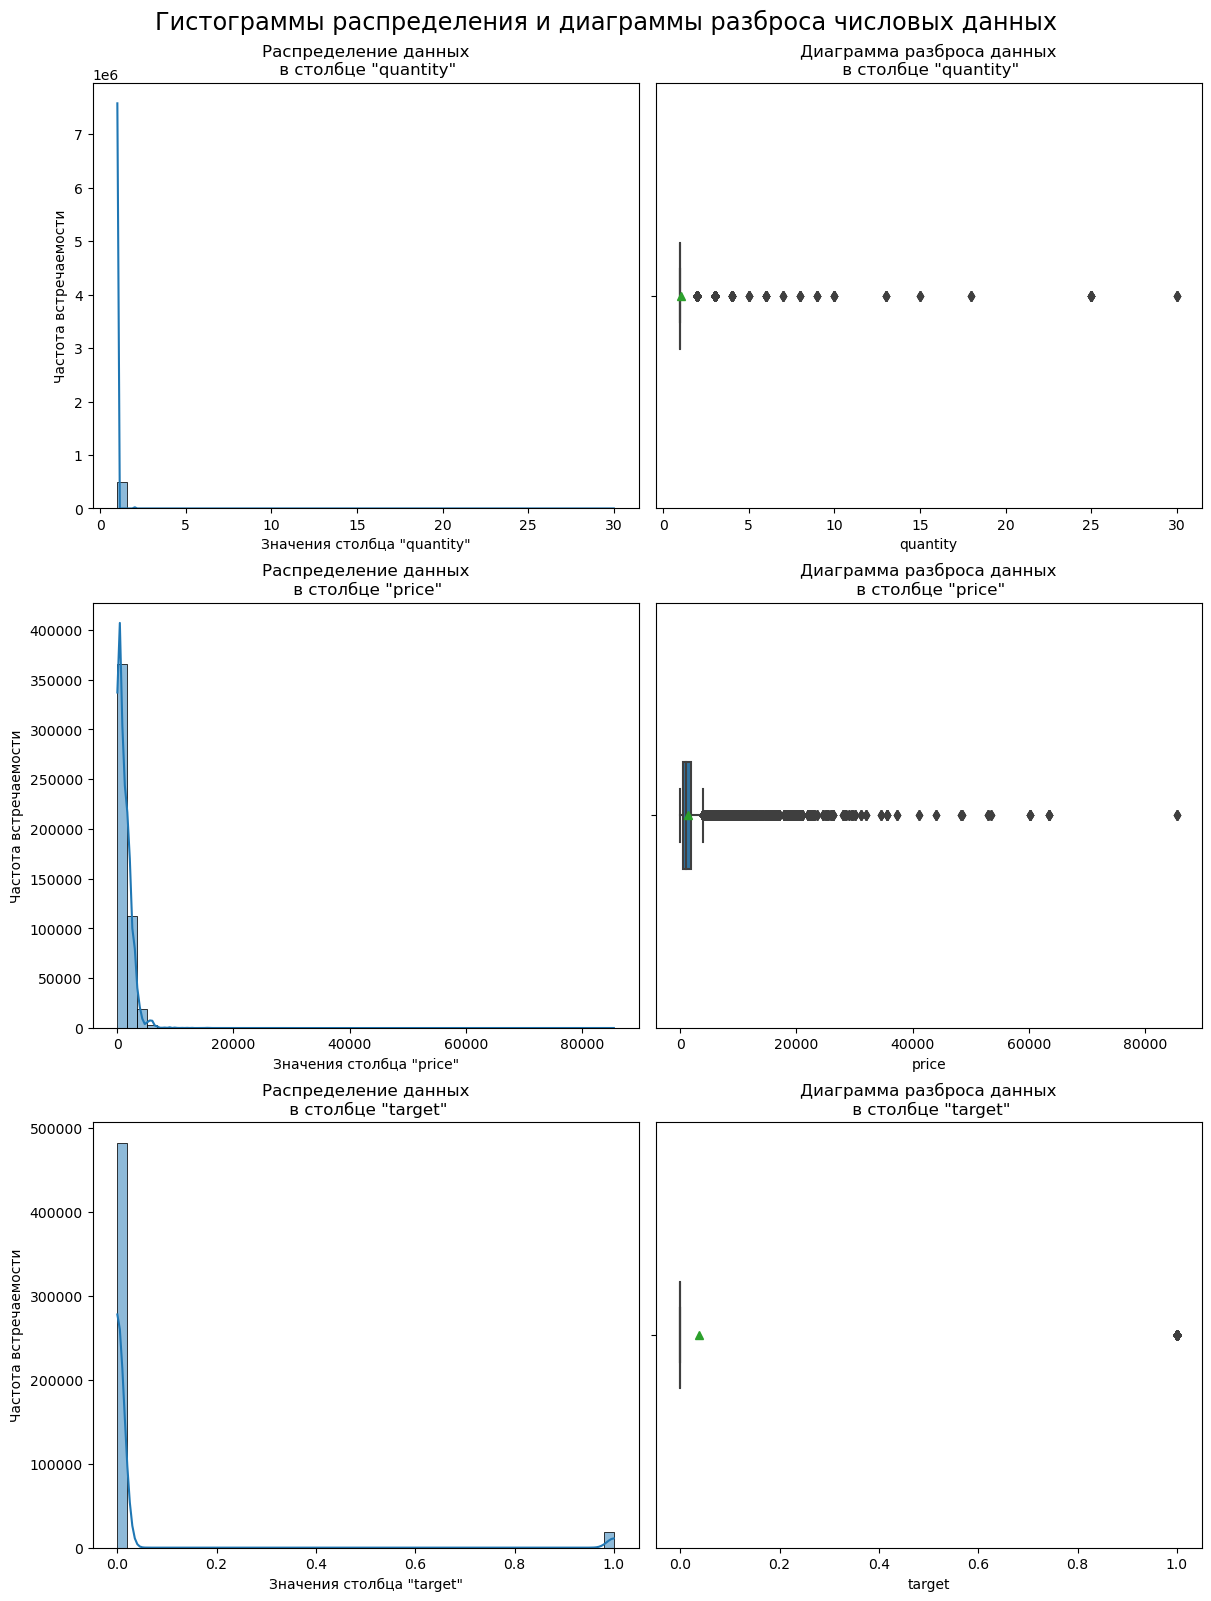

In [53]:
plt.rcParams['figure.constrained_layout.use'] = True # команда, чтобы графики не накладывались друг на друга
data_analysis_num(data_inner[['quantity', 'price', 'target']])

Анализ количественных признаков показал следующее:
- большинство покупок совершены в количестве 1 шт, однако есть исключения - максимальное количество составялет 30 шт.
- средняя цена одной покупки 1287 у.е.. При этом есть выбросы с максимальным значением в 85499 у.е.
- абсолютное большинство пользователей не совершили повторной покупки - 96 %

In [54]:
print('Процент клинетов, которые не совершили повторной покупки:')
round(data_inner[data_inner['target']==0]['target'].count()/data_inner.shape[0]*100, 2)

Процент клинетов, которые не совершили повторной покупки:


96.19

Общие категориальные характеристики датафрейма:


,count,unique,top,freq
event,502107,8,click,173180
channel,502107,2,email,367231



Число категориальных признаков в датафрейме: 2



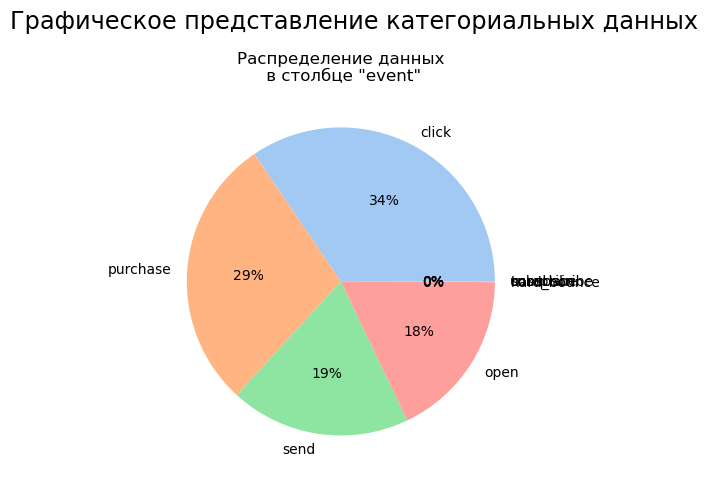

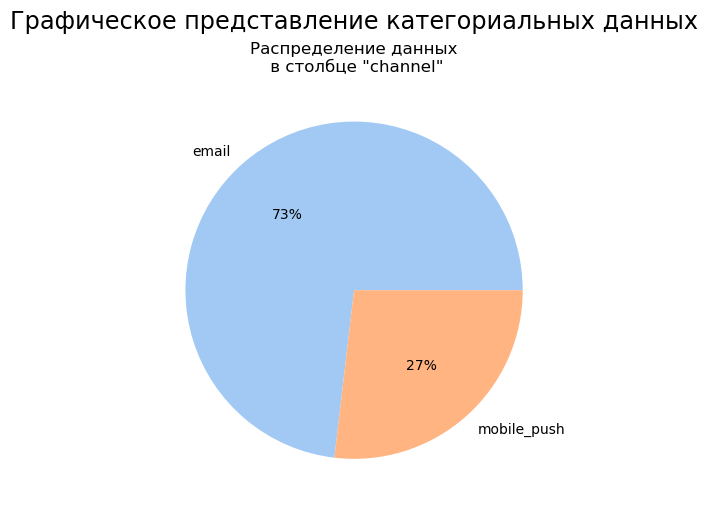

In [55]:
data_analysis_cat(data_inner[['event', 'channel']], figsize=(5, 5))

Анализ категориальных данных показал следующее:
- в столбце `event` наиболее часто представлены значения: `click` - 34%, `purchase` - 29%, `send` - 19%, `open` - 18%. Остальные четыре уникальных значения `complain`, `unsubscribe`, `hard_bounce`, `subscribe` практически не встречаются в данных;
- наиболее популярен канал передачи данных через `email` - 73%. Через `mobile_push` передается только 27 % сообщений.


## Корреляционный анализ

Перед выполнением корреляционного анализа сохраним в отдельные переменные входные и целевой признаки.

In [56]:
target = ['target']
features = data_inner.columns.tolist()
features.remove('target')

Выполним построение матрицы корреляции между входными признаками. Так как в исходном датафрейме содержится большое количество строк, то матрицу будем строить на случайной выборке размером 1000 строк.

Матрица корреляции входных признаков


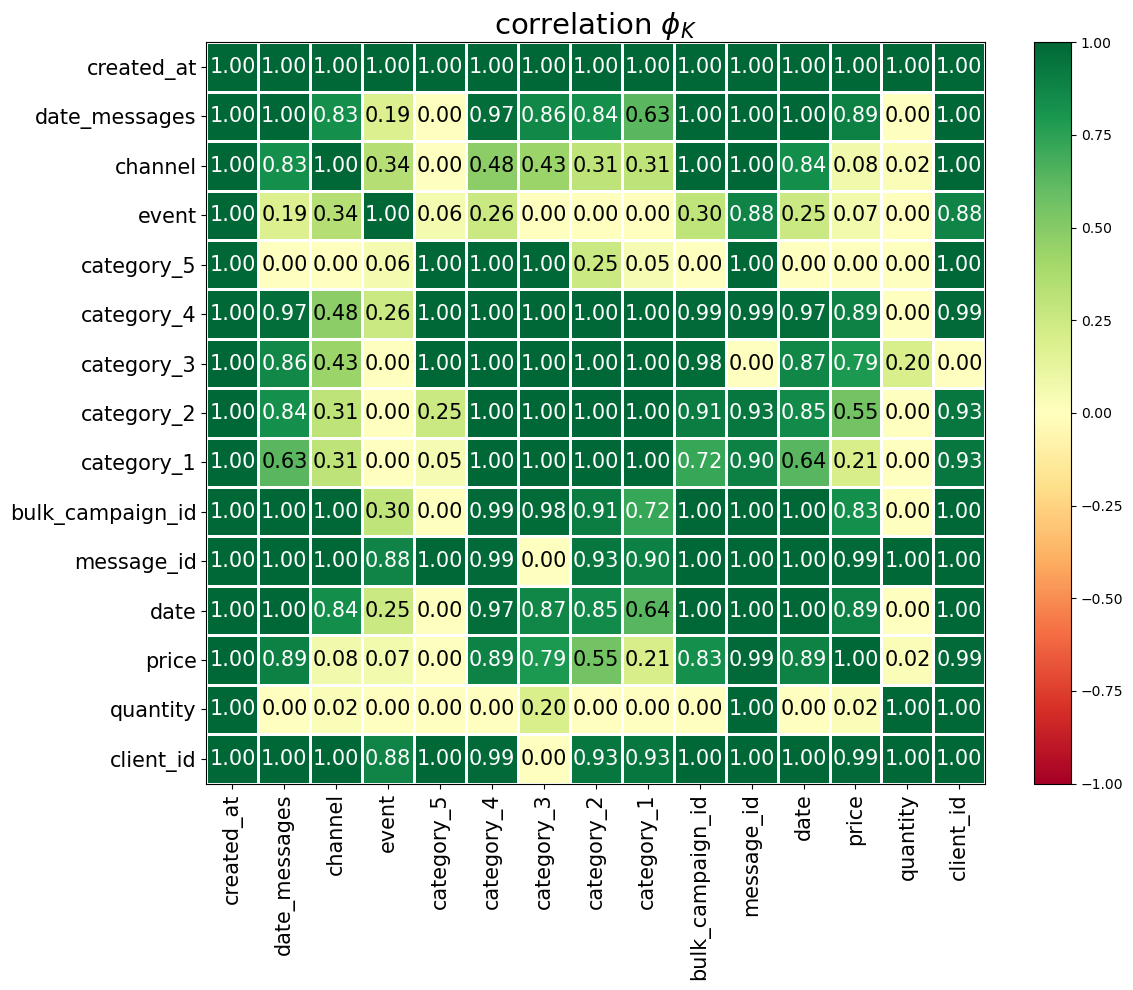

In [57]:
plt.rcParams['figure.constrained_layout.use'] = False

print('Матрица корреляции входных признаков')
# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = data_inner[features].sample(n=1000, random_state=999999).phik_matrix(
    interval_cols=['quantity', 'price', 'target'])

# визуализация тепловой карты коэффициентов корреляции

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    identity_layout=True,
    fontsize_factor=1.5,
    figsize=(12, 10),
    top = 30)

Анализ матрицы корреляций показал, что присутствует большое число признаков с очень высокой корреляцией. Наличие высокой корреляции может негативно сказаться на обучении моделей, поэтому выполним удаление следующих признаков из данных:
- `created_at`.

Остальные признаки пока что оставим. Если результаты обучения будут плохими, то выполним удаление еще некоторых признаков.

Также выполним анализ численных признаков на мультиколлинеарность. Для этого будем вычислять значение VIF.

In [58]:
numeric_columns = data_inner.select_dtypes(include='number').columns.tolist()

data_inner_mc = data_inner[numeric_columns].copy()

list_of_cols = list(data_inner_mc.columns)

# формирование переменной formula_like для использования в методе dmatrices
formula_like = []
for el in list_of_cols:
    formula_str = ''
    formula_str = el+' ~ '
    for el2  in list_of_cols:
        if el != el2:
            formula_str = formula_str+'+'+el2
        else:
            continue
    formula_like.append(formula_str)

# в датафрейм vif будем записывать рассчитанные коэффициенты мультиколлинеарности между входными признаками
vif = pd.DataFrame()
for el1, el2 in zip(formula_like, list_of_cols):
    y, X = dmatrices(formula_like=el1, data=data_inner_mc, return_type='dataframe')
    vif['VIF_'+el2] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable_'+el2] = X.columns

display(vif)

C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide


,VIF_client_id,variable_client_id,VIF_quantity,variable_quantity,VIF_price,variable_price,VIF_message_id,variable_message_id,VIF_bulk_campaign_id,variable_bulk_campaign_id,...,VIF_category_2,variable_category_2,VIF_category_3,variable_category_3,VIF_category_4,variable_category_4,VIF_category_5,variable_category_5,VIF_target,variable_target
0,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept,...,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept
1,1.00,quantity,0.00,client_id,0.00,client_id,1.09,client_id,0.00,client_id,...,0.00,client_id,0.00,client_id,0.00,client_id,0.00,client_id,0.00,client_id
2,1.06,price,1.04,price,1.00,quantity,1.00,quantity,1.00,quantity,...,1.00,quantity,1.00,quantity,1.00,quantity,1.00,quantity,1.00,quantity
3,23.74,message_id,23.38,message_id,23.55,message_id,1.05,price,1.05,price,...,1.04,price,1.04,price,1.05,price,1.04,price,1.04,price
4,1.09,bulk_campaign_id,23.46,bulk_campaign_id,23.47,bulk_campaign_id,1.02,bulk_campaign_id,1.02,message_id,...,23.39,message_id,23.39,message_id,23.34,message_id,23.38,message_id,23.38,message_id
5,30.36,category_1,22.66,category_1,23.79,category_1,22.69,category_1,22.66,category_1,...,23.46,bulk_campaign_id,23.46,bulk_campaign_id,23.46,bulk_campaign_id,23.46,bulk_campaign_id,23.46,bulk_campaign_id
6,83.17,category_2,68.05,category_2,71.55,category_2,68.23,category_2,68.01,category_2,...,13.99,category_1,20.05,category_1,24.67,category_1,22.66,category_1,22.66,category_1
7,59.36,category_3,41.13,category_3,41.78,category_3,41.17,category_3,41.13,category_3,...,20.81,category_3,28.38,category_2,69.68,category_2,68.05,category_2,68.05,category_2
8,1.32,category_4,1.20,category_4,1.20,category_4,1.20,category_4,1.20,category_4,...,1.20,category_4,1.18,category_4,37.80,category_3,41.13,category_3,41.13,category_3
9,1.00,category_5,1.00,category_5,1.00,category_5,1.00,category_5,1.00,category_5,...,1.00,category_5,1.00,category_5,1.00,category_5,1.20,category_4,1.20,category_4


Наблюдается сильная мультиколлинеарность между некоторыми признаками. Удалим из данных следующие столбцы: `message_id`, `category_2`, `category_3`. Выполним повторный расчет коэффициентов.

In [59]:
numeric_columns = data_inner.select_dtypes(include='number').columns.tolist()

In [60]:
numeric_columns.remove('message_id')
numeric_columns.remove('category_3')
numeric_columns.remove('category_2')
data_inner_mc = data_inner[numeric_columns].copy()

list_of_cols = list(data_inner_mc.columns)

# формирование переменной formula_like для использования в методе dmatrices
formula_like = []
for el in list_of_cols:
    formula_str = ''
    formula_str = el+' ~ '
    for el2  in list_of_cols:
        if el != el2:
            formula_str = formula_str+'+'+el2
        else:
            continue
    formula_like.append(formula_str)

# в датафрейм vif будем записывать рассчитанные коэффициенты мультиколлинеарности между входными признаками
vif = pd.DataFrame()
for el1, el2 in zip(formula_like, list_of_cols):
    y, X = dmatrices(formula_like=el1, data=data_inner_mc, return_type='dataframe')
    vif['VIF_'+el2] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable_'+el2] = X.columns

display(vif)

C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Muziukin-DG\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide


,VIF_client_id,variable_client_id,VIF_quantity,variable_quantity,VIF_price,variable_price,VIF_bulk_campaign_id,variable_bulk_campaign_id,VIF_category_1,variable_category_1,VIF_category_4,variable_category_4,VIF_category_5,variable_category_5,VIF_target,variable_target
0,32.83,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept,0.00,Intercept
1,1.00,quantity,1.09,client_id,1.09,client_id,1.01,client_id,1.09,client_id,1.09,client_id,1.09,client_id,1.09,client_id
2,1.04,price,1.04,price,1.00,quantity,1.00,quantity,1.00,quantity,1.00,quantity,1.00,quantity,1.00,quantity
3,1.04,bulk_campaign_id,1.02,bulk_campaign_id,1.02,bulk_campaign_id,1.04,price,1.01,price,1.04,price,1.04,price,1.04,price
4,1.19,category_1,1.02,category_1,1.02,category_1,1.00,category_1,1.00,bulk_campaign_id,1.02,bulk_campaign_id,1.02,bulk_campaign_id,1.02,bulk_campaign_id
5,1.16,category_4,1.16,category_4,1.16,category_4,1.14,category_4,1.03,category_4,1.02,category_1,1.02,category_1,1.02,category_1
6,1.00,category_5,1.00,category_5,1.00,category_5,1.00,category_5,1.00,category_5,1.00,category_5,1.16,category_4,1.16,category_4
7,1.00,target,1.00,target,1.00,target,1.00,target,1.00,target,1.00,target,1.00,target,1.00,category_5


In [61]:
data_inner.drop(columns=['created_at', 'message_id', 'category_2', 'category_3'], inplace=True)

Также удалим все признаки с датой и временем:

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Пришлось удалить признаки даты и времени, так как модели не получается обучить на признаках с типом данных datetime. Вопрос: а вообще при обучении моделей используют признаки даты и/или времени или нет?
</div>

In [62]:
data_inner.drop(columns=['date', 'date_messages'], inplace=True)

### Выводы по разделу

Построение матрицы корреляции показало, что между некоторыми признаками наблюдается сильная коллинеарность и мультиколлинеарность. Для улучшения качества данных были удалены следующие признаки: `created_at`, `message_id`, `category_2`, `category_3`.

## Подготовка выборок

### Разделение исходных данных на тренировочную и тестовую выборки

Выполним разделение исходных данных на тестовую и обучающую выборки в пропорции 1:3.

In [63]:
RANDOM_STATE = 999999
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data_inner.drop('target', axis=1),
    data_inner['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

### Выводы по разделу

На данном этапе исходные данные были разделены на тестовую и тренировочную выборки в пропорции 1:3

## Обучение моделей

Так как перед нами стоит задача бинарной классификации, то в качестве моделей будем использовать следующие:

- LogisticRegression
- DecisionTreeClassifier
- CatBoostClassifier

Сперва создадим списки с числовыми, категориальными и порядковыми признаками:

In [64]:
data_inner.head()

,client_id,quantity,price,bulk_campaign_id,category_1,category_4,category_5,target,event,channel
0,1515915625468169594,1,742.00,7180,2,1569,0,0,send,email
1,1515915625468169594,1,742.00,7180,2,1569,0,0,open,email
2,1515915625468169594,1,742.00,7180,2,1569,0,0,click,email
3,1515915625468169594,1,742.00,7180,2,1569,0,0,open,email
4,1515915625468169594,1,742.00,7180,2,1569,0,0,purchase,email


In [65]:
te_columns = ['client_id', 'bulk_campaign_id',
       'category_1', 'category_4', 'category_5', 'event', 'channel']
num_columns = ['quantity', 'price']
#'category_2', 'category_3', 

Затем создаем пайплайн и словари для перебора гиперпараметров.

In [66]:
te_pipe = Pipeline(
    [
        (
            'te',
            TargetEncoder()
        )
    ]
)

# Запишем в пайплайн `data_preprocessor` шаги по кодированию и масштабированию исходных данных

data_preprocessor = ColumnTransformer(
    [
        ('te', te_pipe, te_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Итоговый пайплайн

pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [88]:
# Список словарей для перебора методов масштабирования и моделей и их гиперпараметров:

param_distributions = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 3)  
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [10, 50] 
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'models__depth': [4, 10] 
    }
] 

Перебор гиперпараметров будем выполнять с помощью GridSearchCV:

In [89]:
grid_search = GridSearchCV(
    pipe_final,
    param_distributions,
    scoring='roc_auc',
    cv=5,
    error_score='raise',
    n_jobs=-1,
    verbose=10)

Выполняем обучение моделей:

In [90]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('te',
                                                                         Pipeline(steps=[('te',
                                                                                          TargetEncoder())]),
                                                                         ['client_id',
                                                                          'bulk_campaign_id',
                                                                          'category_1',
                                                                          'category_4',
                                                                          'category_5',
                                                                          'event',
                                                                          'channel']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['quantity',
                                                                          'price'])])),
                                       ('models',
                                        LogisticRegression(random_state=999999))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(random_state=999999)],
                          'models__C': range(1, 3)},
                         {'models': [DecisionTreeClassifier(random_state=999999)],
                          'models__max_depth': [10, 50]},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x0000013E4C5A8750>],
                          'models__depth': [4, 10]}],
             scoring='roc_auc', verbose=10)

Выведем наилучшую модель, ее параметры и значение метрики ROC_AUC:

In [91]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['client_id',
                                                   'bulk_campaign_id',
                                                   'category_1', 'category_4',
                                                   'category_5', 'event',
                                                   'channel']),
                                                 ('num', StandardScaler(),
                                                  ['quantity', 'price'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000013E26A80990>)])
Метрика лучшей модели на тренировочной выбор

Дополнительно выведем метрики всех обученных моделей:

In [92]:
result = pd.DataFrame(grid_search.cv_results_)
pd.set_option('display.max_colwidth', 255)
display(result[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score'))

,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
5,150.64,0.53,"{'models': <catboost.core.CatBoostClassifier object at 0x0000013E4C5A8750>, 'models__depth': 10}",0.96,1
3,1.99,0.09,"{'models': DecisionTreeClassifier(random_state=999999), 'models__max_depth': 50}",0.93,2
4,82.93,0.13,"{'models': <catboost.core.CatBoostClassifier object at 0x0000013E4C5A8750>, 'models__depth': 4}",0.84,3
2,1.54,0.08,"{'models': DecisionTreeClassifier(random_state=999999), 'models__max_depth': 10}",0.78,4
0,1.91,0.09,"{'models': LogisticRegression(random_state=999999), 'models__C': 1}",0.52,5
1,1.96,0.09,"{'models': LogisticRegression(random_state=999999), 'models__C': 2}",0.52,5


## Выводы по разделу

В ходе обучения были использованы следующие модели:
- LogisticRegression
- DecisionTreeClassifier
- CatBoostClassifier

Обучение и подбор гиперпараметров выявил следующую наилучшую модель: CatBoostClassifier с `depth`=8. Значение метрики данной модели на тренировочных данных составило 0.96.

## Анализ предсказаний лучшей модели на тестовой выборке

Выполним предсказание целевого признака на тестовых данных и рассчитаем метрику ROC_AUC наилучшей модели:

In [93]:
y_pred = grid_search.best_estimator_.predict(X_test)
print('Метрика лучшей модели на тестовой выборке:', roc_auc_score(y_test, y_pred))

Метрика лучшей модели на тестовой выборке: 0.7457389721811243


Как видим, на тестовых данных метрика сильно ниже, чем на тренировочных - 0.75 против 0.96. Однако, так как по заданию минимальная величина метрики должна быть 0.7, то результат в 0.75 нас устраивает.

Теперь воспользуемся функцией `conf_matrix`, чтобы вывести матрицу ошибок для лучшей модели:

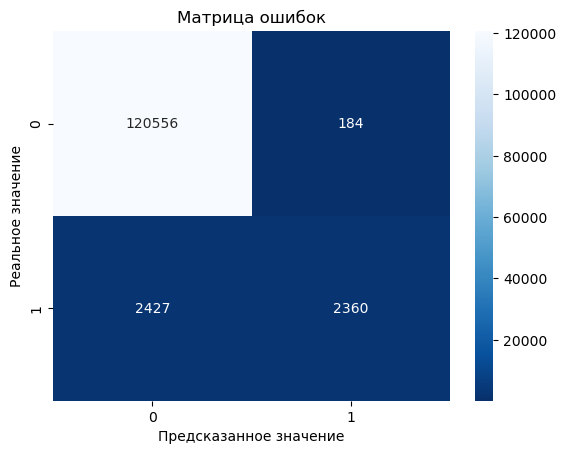

In [101]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
conf_matrix(y_test, y_pred)

На основе полученной матрицы определим величину `precision` - долю верно классифицированных объектов среди всех объектов, которые к этому классу отнес классификатор:

In [105]:
precision = tp/(tp+fp)
print(round(precision, 2))

0.93


## Выводы по разделу

Как видим, полученная модель в целом правильно определяет тех клиентов, которые совершат покупку (класс 1). Метрика `precision` составляет 0.93. При этом метрика `roc_auc` составляет 0.75

## Общие вывод по проекту

В работе проведено предсказание совершения покупки в течение 90 дней среди клиентов интернет-магазина. В качестве исходных данных выступили 2 таблицы с данными о рекламных рассылках, истории покупок. Также для обучения и тестирования моделей была предоставлена таблица с целевым признаком по всем клиентам.

Анализ общей информации о каждом датафрейме показал, что во всех отсутствуют пропущенные значения. Потребовалось изменение типа данных столбцов, содержащих данные о дате и времени, а также сброс индексов в первых двух таблицах.

После выполненной предобработки данных данные из трех датафреймов `apparel_purchases`, `apparel_messages`, `apparel_target_binary` были объединены в один общий датафрейм. Размерность полученной таблицы составила 502107 на 17. В качесте ключа выступили следующие поля: `bulk_campaign_id`, `client_id`, `message_id`.

Анализ количественных и категориальных признаков в полученном датафрейме показал следующее:
- большинство покупок совершены в количестве 1 шт, однако есть исключения - максимальное количество составялет 30 шт.
- средняя цена одной покупки 1287 у.е.. При этом есть выбросы с максимальным значением в 85499 у.е.
- абсолютное большинство пользователей не совершили повторной покупки - 96 %
- в столбце `event` наиболее часто представлены значения: `click` - 34%, `purchase` - 29%, `send` - 19%, `open` - 18%. Остальные четыре уникальных значения `complain`, `unsubscribe`, `hard_bounce`, `subscribe` практически не встречаются в данных;
- наиболее популярен канал передачи данных через `email` - 73%. Через `mobile_push` передается только 27 % сообщений.

В свою очередь, построение матрицы корреляции показало, что между некоторыми признаками наблюдается сильная коллинеарность и мультиколлинеарность. Для улучшения качества данных были удалены следующие признаки: `created_at`, `message_id`, `category_2`, `category_3`.

В ходе обучения были использованы следующие модели:
- LogisticRegression
- DecisionTreeClassifier
- CatBoostClassifier

Обучение и подбор гиперпараметров выявил следующую наилучшую модель: CatBoostClassifier с `depth`=8. Значение метрики данной модели на тренировочных данных составило 0.96. На тестовых данных модель показала результат в 0.75